# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

No need to manipulate data - simply remove odd rows.
Focus is on using spark.

Reviews is open, the rest should be considered as excersises. 


In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import string

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [4]:
df_listings = spark.read.option('header', True)\
                   .option('inferSchema', True)\
                   .option("multiLine", True)\
                   .option('escape', '"').csv('data/listings.csv')
df_reviews = spark.read.option('header', True)\
                   .option('inferSchema', True)\
                   .option("multiLine", True)\
                   .option('escape', '"').csv('data/reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [146]:
# The Schemas are printed for both datasets.
df_listings.printSchema()
df_reviews.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

The listings.csv dataset is a collection of listings from AirBnB and all associated data stored in a csv-format.
The reviews.csv dataset are reviews of the various listings in AirBnb. In this dataset the column 'listing_id' can be used to link to the listing in listings.csv.

In [136]:
# We run a count function to determine the length of both datasets:
print('Listings count:', df_listings.count())
print('Reviews count:',df_reviews.count())

Listings count: 1330480
Reviews count: 32297300


### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

---
It was noted that NULLs occur differently in between the columns (example below), meaning that simply removing all rows with NULLs will remove more or less all data.

To illustrate this, we have shows the three different neighbour columns for the city 'Agia Galini':

In [190]:
df_listings.select('neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed')\
        .filter(f.col('city')=='Agia Galini').show()

+-------------+----------------------+----------------------------+
|neighbourhood|neighbourhood_cleansed|neighbourhood_group_cleansed|
+-------------+----------------------+----------------------------+
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|                        null|
|         null|       Αγίου Βασιλείου|          

Instead, it was found that a lot of entries contained nothing but the column titles. These were removed by filtering out all IDs with a values of 'id'.
A count was performed to get a feeling of how much smaller the dataset has become.

In [5]:
#filtered_listings = df_listings
filtered_listings = df_listings.filter(f.col('id') != 'id')
filtered_listings.count()

1330385

Depending on the specific questions, further data preparation steps may be done.

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

---
We group by the city column and compute the aggregate functions count and count destinct on the 'neighbourhood_cleansed' column. To show the most interesting cities, we order by the column with the count of distinct neighbourhoods.

In [139]:
filtered_listings.filter(f.col('city').isNotNull()).groupBy('city')\
         .agg(f.count('neighbourhood_cleansed').alias('Count'),\
         f.countDistinct('neighbourhood_cleansed').alias('Distinct neighbourhoods'))\
         .orderBy(f.desc('Distinct neighbourhoods')).show()

+--------------+-----+-----------------------+
|          city|Count|Distinct neighbourhoods|
+--------------+-----+-----------------------+
|Rio de Janeiro|19321|                    145|
|   Los Angeles|27763|                    145|
|       Toronto|21760|                    140|
|        Berlin|24271|                    138|
|        Madrid|20642|                    128|
|       Oakland| 3122|                    124|
|      New York|21457|                    120|
|     Edinburgh|13339|                    111|
|       Sevilla| 5532|                    103|
|      Portland| 4548|                     94|
|           Rio| 2180|                     94|
|     Cape Town|21895|                     93|
|       Seattle| 9017|                     89|
|        Milano|17837|                     86|
|     San Diego|12408|                     85|
|        Girona|  759|                     82|
|      València| 5466|                     81|
|      Valencia| 1331|                     79|
|        Denv

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

---
We chose to work with Oakland, as it had relatively many distinct neighbourhoods and number of listings.
In order to save time and processing power in the following computations, we persisted the newly created dataset 'Oakland'.
To compute the number of listings with different property types per neighbourhood, we group by the neighbourhood and use the count distinct aggregate function. Finally, we order by the count.

In [6]:
# We filter for the city and remove NULLs
Oakland = filtered_listings.filter(f.col('city') == 'Oakland').filter(f.col('price').isNotNull()).persist()
oakland_count = Oakland.groupBy('neighbourhood')\
        .agg(f.countDistinct('property_type').alias('Distinct Property Types'))\
        .orderBy(f.desc('Distinct Property Types'))
oakland_count.show()

+--------------------+-----------------------+
|       neighbourhood|Distinct Property Types|
+--------------------+-----------------------+
|             Oakland|                     22|
|        East Oakland|                     12|
|       North Oakland|                     12|
|       Oakland Hills|                     10|
|        West Oakland|                      9|
|         Lower Hills|                      8|
|            Prescott|                      7|
|Southeast Oakland...|                      7|
|     Northwest Hills|                      7|
|Central East Oakland|                      7|
|             Bushrod|                      7|
|            Elmhurst|                      7|
|    Downtown Oakland|                      6|
|           Fruitvale|                      5|
|         Adams Point|                      5|
|            Temescal|                      5|
|     Redwood Heights|                      5|
|           Montclair|                      5|
|            

The visiualize the counts we use pandas and matplotlib to make a simple bar chart.

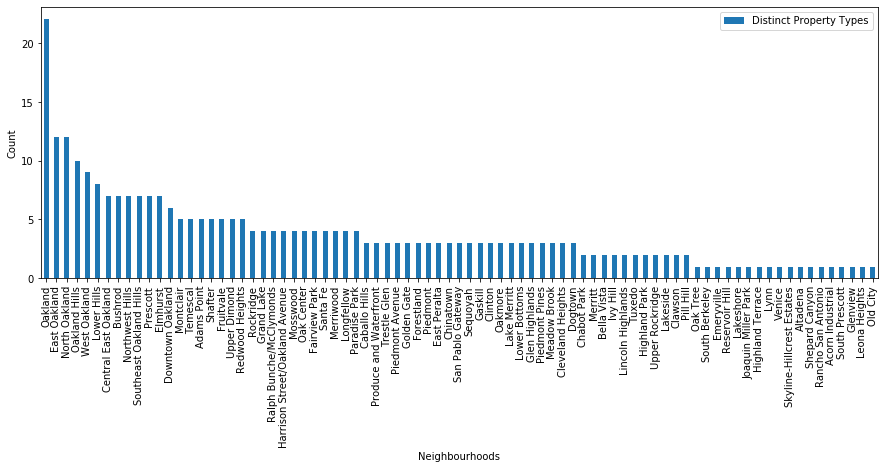

In [141]:
disPropType = oakland_count.toPandas()
disPropType.plot.bar('neighbourhood','Distinct Property Types', figsize = (15,5))\
        .set(ylabel = 'Count', xlabel = 'Neighbourhoods')


We see that the neighbourhood 'Oakland' has the highest number of listings, which is sensible as often the majority of the listings lie around the center of a city.

## Prices
Compute the minimum, maximum and average listing price in your city. 

We list the first 100 entries, to see the format of the values.

In [142]:
Oakland.select('price').show(100)

+---------+
|    price|
+---------+
|  $164.00|
|   $52.00|
|   $65.00|
|  $100.00|
|  $141.00|
|   $70.00|
|  $110.00|
|  $141.00|
|  $150.00|
|  $200.00|
|  $110.00|
|  $245.00|
|  $148.00|
|   $90.00|
|   $65.00|
|   $68.00|
|  $119.00|
|  $148.00|
|  $129.00|
|  $225.00|
|   $89.00|
|   $89.00|
|  $108.00|
|  $230.00|
|  $150.00|
|   $75.00|
|  $105.00|
|  $300.00|
|   $55.00|
|   $83.00|
|   $69.00|
|  $195.00|
|   $89.00|
|   $79.00|
|  $102.00|
|   $99.00|
|  $120.00|
|   $72.00|
|  $160.00|
|  $165.00|
|   $89.00|
|  $110.00|
|   $88.00|
|  $200.00|
|  $375.00|
|  $135.00|
|  $150.00|
|  $105.00|
|   $99.00|
|   $85.00|
|   $69.00|
|   $99.00|
|  $200.00|
|   $40.00|
|$2,500.00|
|  $125.00|
|  $225.00|
|  $145.00|
|   $75.00|
|   $52.00|
|  $193.00|
|   $40.00|
|  $349.00|
|  $350.00|
|   $80.00|
|  $115.00|
|  $130.00|
|$2,400.00|
|  $269.00|
|   $96.00|
|  $280.00|
|   $89.00|
|   $76.00|
|  $800.00|
|   $95.00|
|   $76.00|
|   $79.00|
|  $105.00|
|   $90.00|
|  $220.00|
|   

We notice that the '$' sign is consistently present, and that both , and . appears. This will be needed to be delt with in order for us to handle them as numbers.

In [7]:
# First, we make a new column that removes '$' and ',' from a value.
# Then we cast the values to the float type, drop the old price and rename the newly created.

Oakland = Oakland.withColumn('Price_', f.translate(f.col('price'),'$,','')\
        .cast('float')).drop('price').withColumnRenamed('Price_','Price')

# We filtered out NULLs and decided to only include listings with a price above 0,
# as it was concluded that these must be typos. Then, the aggregate functions min, max, and avg were computed:
Oakland.filter(f.col('Price').isNotNull()).filter(f.col('Price') > 0)\
        .select(f.min(f.col('Price')).alias('Minimum ($)'),\
        f.max(f.col('Price')).alias('Maximum ($)')\
        ,f.avg(f.col('Price')).alias('Averiage [$]')).show()

+-----------+-----------+------------------+
|Minimum ($)|Maximum ($)|      Averiage [$]|
+-----------+-----------+------------------+
|       16.0|     3150.0|129.84748478051907|
+-----------+-----------+------------------+



We can now conclude that the cheapest listing costs \$16 per night, while the most expensive costs \$3150. The average cost lies around \$130.

---

Compute and visualize the distribution of listing prices in your city.

---
We convert the Oakland prices to a pandas dataframe to plot a histogram over it.

[Text(0, 0.5, 'Number of listings'), Text(0.5, 0, 'Price')]

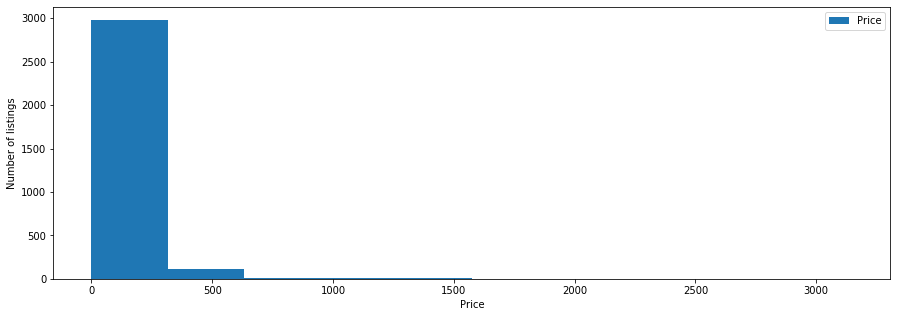

In [185]:
oak_prices = Oakland.select('Price').toPandas()
oak_prices.plot.hist(figsize = (15, 5))\
        .set(ylabel='Number of listings', xlabel='Price')

We see that the vast majority of AirBnB listings for our site are in the price range of the average listing price.
Vary few are \> \$1000, therefore, to get a feeling of the distribution below this price, we filtered the prices above \$500 out:

[Text(0, 0.5, 'Number of listings'), Text(0.5, 0, 'Price')]

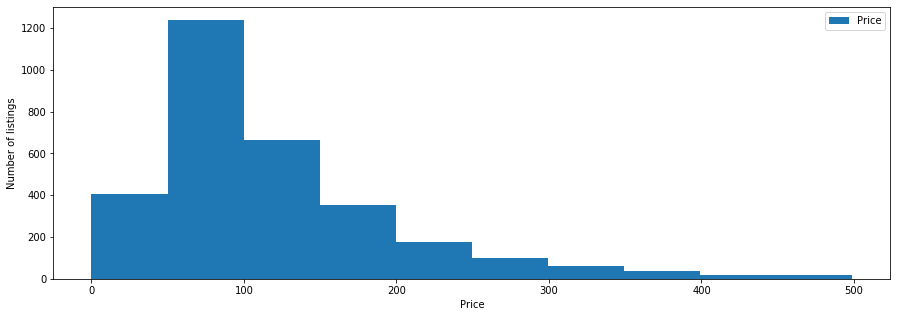

In [186]:
oak_prices = pd.DataFrame(Oakland.filter(f.col('Price') < 500).select('Price').toPandas())
oak_prices.plot.hist(figsize = (15, 5))\
        .set(ylabel='Number of listings', xlabel='Price')


This gives a much nicer view of the distribution in the lower end of the price range.
We can conclude that the majority of listings have prices near \$50-150 per night, so just around the average listing price.

---

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

To do this, we first create a new column with the value, calculated as descibred above. We then make a window partitioned by the neighbourhood, which is ordered by the value.

We then compute the value ranks with the rank function over the created window. The result is printed by filtering ranks \< 3 and selecting the appropriate columns.

In [147]:
# Calculate value:
Oakland_score = Oakland.filter(f.col('review_scores_rating').isNotNull())\
        .withColumn('Value', f.col('review_scores_rating').cast('float')/f.col('price'))
# Create window:
sorted_by_hood_window = Window.partitionBy('neighbourhood').orderBy(f.desc('Value'))
# Make rank and filter results:
ranked_oakland = Oakland_score.withColumn('ValueRank', f.rank().over(sorted_by_hood_window))
ranked_oakland = ranked_oakland.filter(f.col('ValueRank') <= 3).orderBy('Neighbourhood', f.desc('Value'))\
        .select('Neighbourhood','Value','ValueRank')
ranked_oakland.show(10000)

+--------------------+------------------+---------+
|       Neighbourhood|             Value|ValueRank|
+--------------------+------------------+---------+
|         Adams Point|3.4642857142857144|        1|
|         Adams Point|             2.325|        2|
|         Adams Point|1.8181818181818181|        3|
|         Bella Vista|             1.225|        1|
|         Bella Vista|0.5344827586206896|        2|
|             Bushrod|2.3846153846153846|        1|
|             Bushrod|               2.0|        2|
|             Bushrod|1.8148148148148149|        3|
|       Caballo Hills|               2.0|        1|
|       Caballo Hills|1.7636363636363637|        2|
|       Caballo Hills|1.5833333333333333|        3|
|Central East Oakland| 4.318181818181818|        1|
|Central East Oakland| 4.086956521739131|        2|
|Central East Oakland|3.9565217391304346|        3|
|         Chabot Park|1.7636363636363637|        1|
|           Chinatown|3.3333333333333335|        1|
|           

We see that it is not all neighbourhoods that have more than 1 or 2 listings, so a top 3 of those cannot be shown.


## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

---
For this the reviews.csv dataset is needed. In order to associate the relevant reviews with their appropriate listing, we did a broadcast inner join of the listing_id in reviews_df and id (renamed to id_) from Oakland.
The new dataset was persisted to make future computations faster.

In [9]:
Oakland_ids = Oakland.select('id','neighbourhood').withColumnRenamed('id','id_')
Oakland_reviews = df_reviews.join(f.broadcast(Oakland_ids),\
        (f.col('listing_id') == f.col('id_')), 'inner').drop('id_').persist()
Oakland_reviews.show(5)

+----------+--------+----------+-----------+-------------+--------------------+-------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|neighbourhood|
+----------+--------+----------+-----------+-------------+--------------------+-------------+
|      3083|16797662|2014-08-02|   18272366| Carlos Kenji|B- love guest hou...| West Oakland|
|      3083|19980893|2014-09-21|    4400249|        Jason|The description w...| West Oakland|
|      3083|21720882|2014-10-22|    4268642|       Carmen|B-Love makes me f...| West Oakland|
|      3083|27107155|2015-02-25|   23674350|      Matthew|Simple but effect...| West Oakland|
|      3083|33318077|2015-05-26|    1252519|        Pavel|I enjoyed staying...| West Oakland|
+----------+--------+----------+-----------+-------------+--------------------+-------------+
only showing top 5 rows



The reviews were grouped by the date, counted and then ordered.
The result was plotted to show the popularity over time.

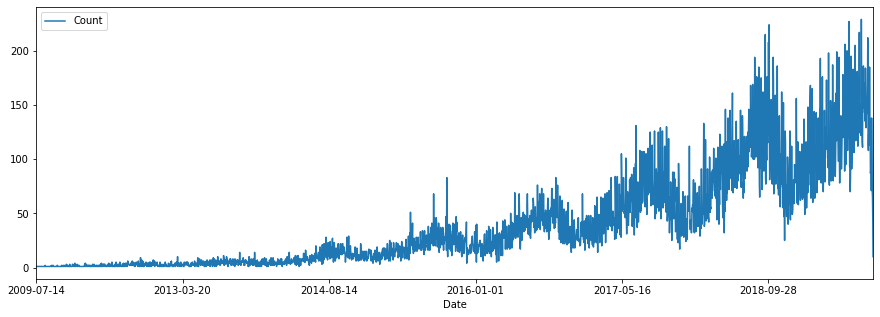

In [161]:
review_time = Oakland_reviews.groupBy('Date').count()\
        .withColumnRenamed('count','Count').orderBy(f.col('Date'))

review_time = review_time.toPandas()
review_time.plot('Date','Count', figsize=(15,5))

We see thath the city was not very popular in the early days of AirBnB, which makes sense. Interestingly, we see huge deviations in popularity, probably caused by the seasons.

---

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

---
We selected 5 neighbourhoods, and plotted their individual popularity over time.
We chose to only look at months, as it gave a nicer overview and made the seasons more clear.

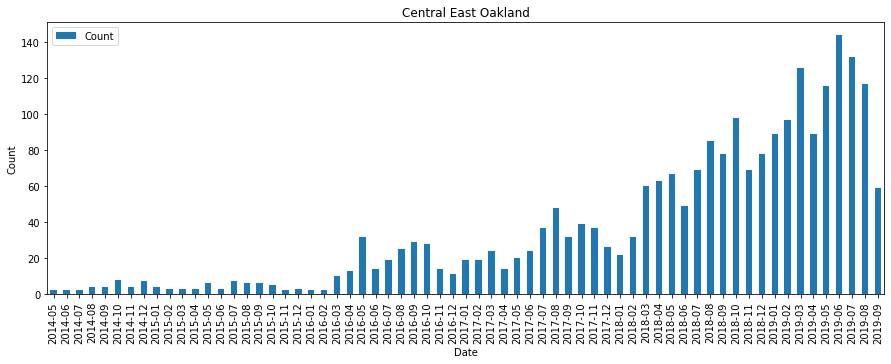

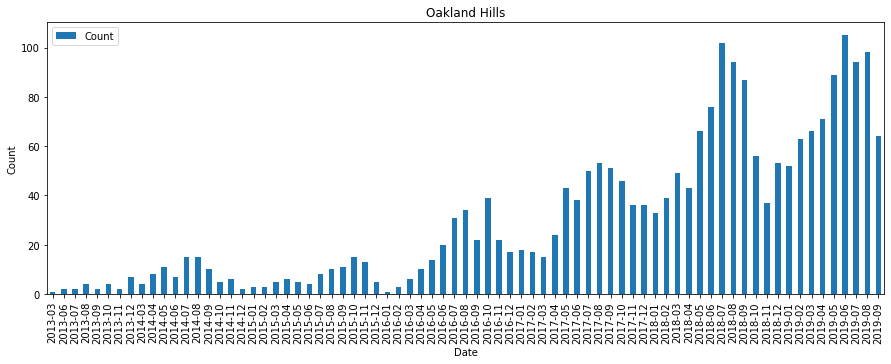

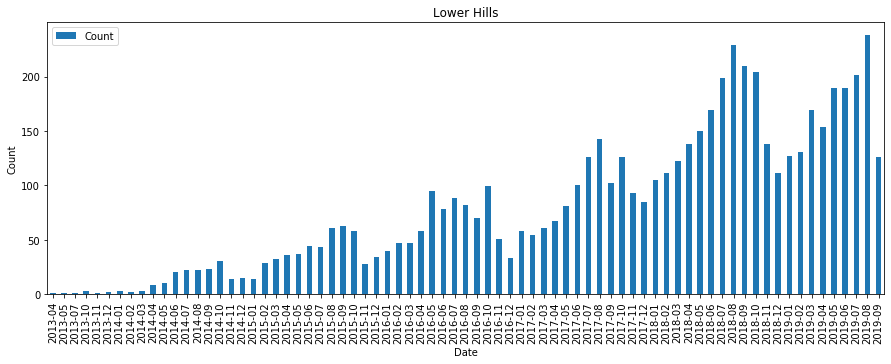

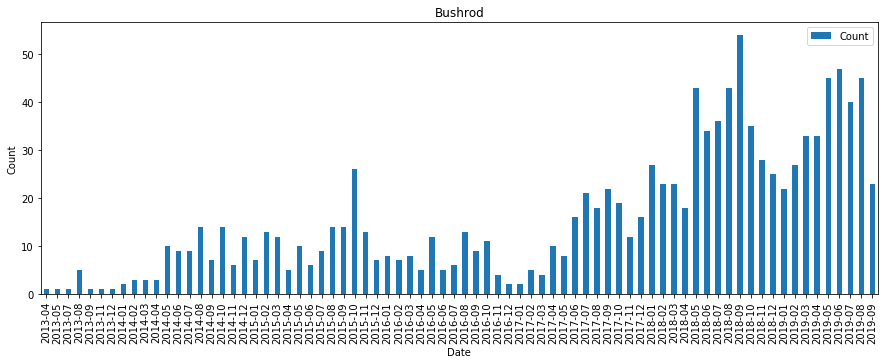

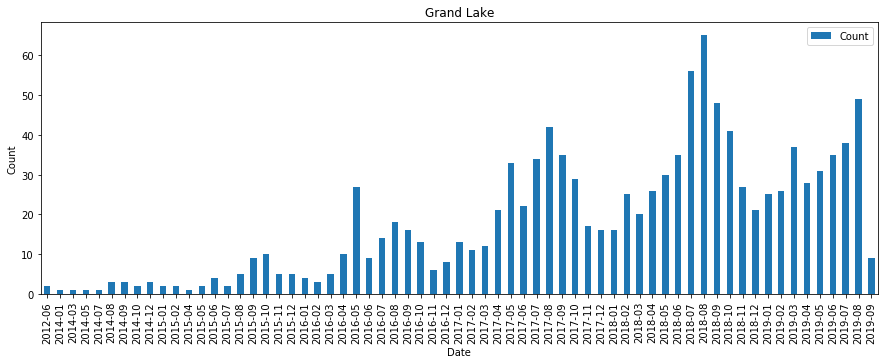

In [174]:
cool_hoods = ['Central East Oakland', 'Oakland Hills', 'Lower Hills', 'Bushrod', 'Grand Lake']

for hood in cool_hoods:
    Oakland_reviews.filter(f.col('neighbourhood') == hood)\
        .withColumn('date_mth', f.col('date').substr(0, 7))\
        .groupBy('date_mth').count().orderBy(f.col('date_mth'))\
        .withColumnRenamed('count','Count').toPandas()\
        .plot.bar('date_mth','Count', figsize = (15,5), title = hood).set(ylabel='Count', xlabel='Date')


Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

---
To make this more clear, we chose to only look at the year 2018.

[Text(0, 0.5, 'Count'), Text(0.5, 0, '(Year-Month)')]

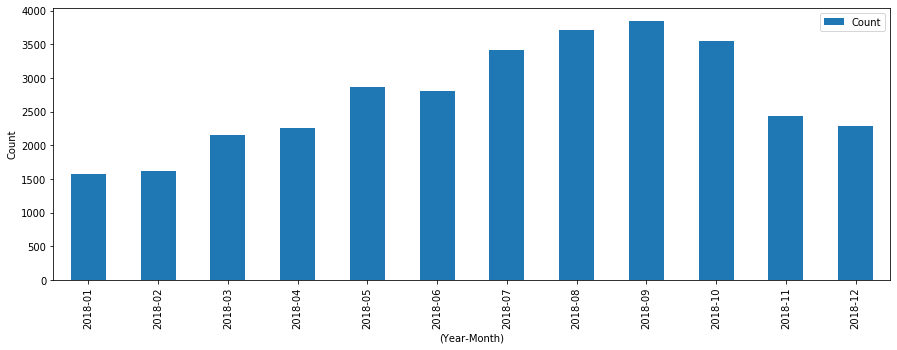

In [10]:
seasons = Oakland_reviews.select('date')\
        .filter(f.split(f.col('date'),'-')[0] == '2018')\
        .withColumn('date_mth', f.col('date').substr(0, 7))\
        .groupBy('date_mth').count().orderBy(f.col('date_mth'))\
        .select('Date_mth','Count').toPandas()

seasons.plot.bar('Date_mth','Count',figsize=(15,5)).set(ylabel = 'Count', xlabel = '(Year-Month)')


We see a trend that Oakland is most popular during the mid-late summer months (July, August, September, and October).

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In [11]:

Oakland_rating = Oakland.filter(f.col('review_scores_rating').isNotNull())\
        .withColumn('Rating', f.col('review_scores_rating').cast('float'))\
        .drop('review_scores_rating').select('id','Rating').withColumnRenamed('id','id_')
Oakland_reviews = df_reviews.join(f.broadcast(Oakland_rating),\
        (f.col('listing_id') == f.col('id_')), 'inner').drop('id_').persist()
Oakland_reviews.show(5)

+----------+--------+----------+-----------+-------------+--------------------+------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|Rating|
+----------+--------+----------+-----------+-------------+--------------------+------+
|      3083|16797662|2014-08-02|   18272366| Carlos Kenji|B- love guest hou...|  91.0|
|      3083|19980893|2014-09-21|    4400249|        Jason|The description w...|  91.0|
|      3083|21720882|2014-10-22|    4268642|       Carmen|B-Love makes me f...|  91.0|
|      3083|27107155|2015-02-25|   23674350|      Matthew|Simple but effect...|  91.0|
|      3083|33318077|2015-05-26|    1252519|        Pavel|I enjoyed staying...|  91.0|
+----------+--------+----------+-----------+-------------+--------------------+------+
only showing top 5 rows



In [339]:
import string

def remove_punct(text):
    
    return text.lower().translate(str.maketrans('', '', '0123456789\n\t'+string.punctuation))#maketrans('', '', string.punctuation))

def update_dict(d):
    for key in d.keys():
        if key not in full_dict:
            full_dict[key] = [int(val) for val in d[key]]
        else:
            full_dict[key] = [int(full_dict[key][0])+int(d[key][0]), int(full_dict[key][1])+int(d[key][1])]
    
    

word_dict = dict()
def update_word_dict(rating, wordlists):
    #global word_dict
    for wordlist in wordlists:
        for word in wordlist:
            if word == '': continue
            if word not in word_dict:
                word_dict[word] = [int(rating), 1]
            else:
                word_dict[word][0] += int(rating)
                word_dict[word][1] += 1
    return word_dict

spark.udf.register("wordScorer", update_word_dict)
wordScorer = f.udf(update_word_dict, StringType())
spark.udf.register("removePunct", remove_punct)
removePunct = f.udf(remove_punct, StringType())
spark.udf.register("updateDict", update_dict)
updateDict = f.udf(update_dict, StringType())

In [245]:

#sample2 = sample.rdd.map(customFunction)

In [229]:


test = Oakland_reviews.select('comments','Rating').filter(f.col('comments').isNotNull()).withColumn('Word_list',\
        f.split(removePunct(f.col('comments')),' ')).drop('comments')\
        .withColumn('word_dict', wordScorer(f.col('Rating'), f.col('Word_list')))\
        .drop('Word_list').show()#.groupBy('Rating')#.agg(updateDict(f.col('word_dict')).alias('test')).show()#.rdd.map(customFunction)
#test.groupBy('Rating').agg(updateDict(f.col('word_dict'))).show()

+------+--------------------+
|Rating|           word_dict|
+------+--------------------+
|  91.0|{a=[637, 7], b=[2...|
|  91.0|{a=[1365, 15], b=...|
=[91, 1], a=[22...|
|  91.0|{a=[455, 5], b=[2...|
|  91.0|{a=[2821, 31], b=...|
|  91.0|{a=[2093, 23], b=...|
|  91.0|{a=[637, 7], c=[3...|
|  91.0|{a=[1092, 12], b=...|
|  91.0|{a=[728, 8], b=[1...|
=[364, 4], a=[5...|
|  91.0|{a=[1729, 19], b=...|
|  91.0|{a=[910, 10], c=[...|
|  91.0|{a=[728, 8], b=[9...|
|  91.0|{a=[910, 10], b=[...|
|  91.0|{a=[1456, 16], b=...|
|  91.0|{a=[637, 7], c=[2...|
|  91.0|{a=[2639, 29], b=...|
|  91.0|{a=[1456, 16], b=...|
|  91.0|{a=[364, 4], c=[9...|
|  91.0|{’=[273, 3], a=[2...|
+------+--------------------+
only showing top 20 rows



In [240]:
word_dict = dict()


In [316]:
test = Oakland_reviews.select('comments','Rating').filter(f.col('comments').isNotNull()).withColumn('Word_list',\
        f.split(removePunct(f.col('comments')),' ')).drop('comments')\
        .groupBy('Rating').agg(f.collect_list('Word_list').alias('longlist'))\
        .withColumn('longdict', wordScorer(f.col('Rating'), f.col('longlist'))).drop('longlist').toPandas()
                    #.withColumn('Word', f.col(''))
        #.withColumn('word_dict', wordScorer(f.col('Rating'), f.col('Words')))#.rdd.map(customFunction)

test

,Rating,longdict
0,82.0,"{cancel=[82, 1], nicely=[82, 1], half=[164, 2]..."
1,90.0,"{cancel=[450, 5], nicely=[1890, 21], half=[144..."
2,86.0,"{nicely=[258, 3], prepare=[86, 1], half=[172, ..."
3,91.0,"{busses=[958, 10], cancel=[677, 7], cca=[99, 1..."
4,99.0,"{busses=[958, 10], cancel=[677, 7], cca=[99, 1..."
5,89.0,"{cca=[89, 1], cancel=[89, 1], busses=[89, 1], ..."
6,100.0,"{busses=[685, 7], expained=[97, 1], unavailabl..."
7,97.0,"{busses=[685, 7], expained=[97, 1], unavailabl..."
8,67.0,"{parking=[201, 3], very=[335, 5], gotten=[67, ..."
9,70.0,"{nicely=[70, 1], been=[72, 1], moderna=[72, 1]..."


In [343]:
#test = test.toPandas()
word_dict= dict()
full_dict = dict()

for d in test['longdict']:
    d = d[1:-1].replace('], ', ']!!!')
    d = d.split('!!!')
    new_d = dict()
    for element in d:
        element = element.split('=')
        element[1] = element[1][1:-1].split(', ')
        new_d[element[0]] = list(element[1])
    
    update_dict(new_d)



{'cancel': [9091, 98], 'nicely': [177905, 1841], 'half': [79997, 836], 'unavailable': [1282, 14], 'spacious': [946840, 9815], 'shooting': [1878, 20], 'undergoing': [2892, 31], 'hall': [30501, 317], 'owners': [62134, 645], 'your': [899419, 9349], 'bearable': [1015, 11], 'without': [202633, 2109], 'tea': [170774, 1763], 'would': [3415940, 35433], 'culturally': [851, 9], 'legs': [3536, 37], 'essentials': [49351, 513], 'ten': [26313, 273], 'pics': [16332, 170], 'solid': [23551, 247], 'earplugsi': [462, 5], 'apparent': [4521, 48], 'cooperative': [4295, 45], 'frills': [9015, 97], 'left': [363707, 3784], 'reserved': [12641, 133], 'attendingthe': [82, 1], 'much': [903802, 9385], 'wind': [7535, 78], 'accessible': [153393, 1593], 'wasn’t': [56735, 601], 'hang': [87978, 917], 'restful': [34363, 354], 'independent': [11958, 124], 'weil': [2670, 28], 'hosting': [62430, 649], 'ahead': [23479, 245], 'turn': [31255, 329], 'youre': [285150, 2971], 'arrived': [365458, 3806], 'same': [112101, 1173], 'aft

In [369]:

df = spark.createDataFrame(pd.DataFrame.from_dict(full_dict, orient='index').reset_index())\
     .withColumnRenamed('index', 'word').withColumnRenamed('0','sum').withColumnRenamed('1','count')


In [370]:
df.show()

+-----------+-------+-----+
|       word|    sum|count|
+-----------+-------+-----+
|     cancel|   9091|   98|
|     nicely| 177905| 1841|
|       half|  79997|  836|
|unavailable|   1282|   14|
|   spacious| 946840| 9815|
|   shooting|   1878|   20|
| undergoing|   2892|   31|
|       hall|  30501|  317|
|     owners|  62134|  645|
|       your| 899419| 9349|
|   bearable|   1015|   11|
|    without| 202633| 2109|
|        tea| 170774| 1763|
|      would|3415940|35433|
| culturally|    851|    9|
|       legs|   3536|   37|
| essentials|  49351|  513|
|        ten|  26313|  273|
|       pics|  16332|  170|
|      solid|  23551|  247|
+-----------+-------+-----+
only showing top 20 rows



In [374]:
df.filter(f.col('count') > 100).withColumn('positivity',f.col('sum')/f.col('count')).orderBy(f.desc('positivity')).show()

+-----+--------+------+-----------------+
| word|     sum| count|       positivity|
+-----+--------+------+-----------------+
|  and|36235018|375449|96.51115863938911|
|  the|33336325|346814| 96.1216242712232|
|    a|21902971|227576|96.24464354765001|
|   to|20571590|213778|96.22875132146433|
|  was|17556742|182645|96.12495277724548|
|   is|13271998|137795|96.31697811967052|
|   in|11399423|118462|96.22852053823166|
|    i| 9419612| 97972|96.14596007022415|
| very| 9283970| 96418|96.28876350888838|
|   we| 8956633| 92791|96.52480305202013|
|  for| 8719512| 90686|96.15058553690757|
|great| 8282034| 86002|96.30048138415385|
|place| 8216077| 85368|96.24305360322369|
|   of| 8044553| 83551| 96.2831444267573|
| stay| 7539607| 78189|96.42797580222282|
| with| 6711078| 69587|96.44154799028554|
|   it| 6406139| 66710|96.02966571728376|
|  you| 4829792| 50183|96.24358846621365|
| this| 4535110| 47075|96.33797132235794|
|clean| 4272023| 44342|96.34258716341166|
+-----+--------+------+-----------

In [383]:
df.filter(f.col('count') > 2500).withColumn('positivity',f.col('sum')/f.col('count')).orderBy(f.desc('positivity')).show()

+----------+-------+-----+-----------------+
|      word|    sum|count|       positivity|
+----------+-------+-----+-----------------+
|   touches| 385797| 3952|97.62069838056681|
|thoughtful| 372691| 3819|97.58863576852579|
|   stylish| 305627| 3132|97.58205619412516|
|   cottage| 652762| 6693|97.52906021216197|
|    modern| 272407| 2796|97.42739628040057|
| decorated| 352618| 3620|97.40828729281768|
|     hosts|1372293|14108|97.27055571307059|
|  peaceful| 343237| 3529|97.26183054689714|
| beautiful|1929020|19835|97.25334005545753|
|     fresh| 243536| 2505|97.21996007984032|
|    return| 274245| 2821| 97.2155264090748|
|      hope| 268605| 2763|97.21498371335505|
|absolutely| 479900| 4937|97.20478023090946|
| breakfast| 364127| 3747| 97.1782759540966|
|  relaxing| 294502| 3031|97.16331243813923|
|     their| 930373| 9577|97.14660123211861|
|    highly|1276491|13140|97.14543378995434|
|    garden| 581693| 5989|97.12689931541159|
| wonderful|1555447|16015|97.12438339057134|
|      eve

In [319]:
Oakland.select('id').show(5)

+--------+
|      id|
+--------+
|11844122|
|14041816|
|14539422|
|19164553|
|19998762|
+--------+
only showing top 5 rows

